# **Saudi Used Cars**

## Business Problem 

**Context**

Banyak pemilik mobil yang ingin menjual mobil miliknya, hanya saja ia tidak mengetahui harga pasaran. Sehingga harga yang dimasukan awalnya adalah 0 dan dapat di tawar, dengan harapan harga yang ditawarkan oleh salah satu calon pembeli adalah harga tertinggi

**Problem Statement**

Pemilik mobil terkadang tidak mengetahui nilai mobil mereka ketika ingin menjual mobil miliknya, sehingga pemilik mobil memasukan harga mobil yang terlalu murah atau terlalu mahal. Harga mobil yang terlalu murah dapat mengakibatkan rusaknya harga mobil lain yang ada di pasar.

Meski harga jual adalah kebebasan kita, akan lebih baik jika kita dapat memberikan kisaran harga mobil lainnya yang dijual di platform tersebut untuk menjadi pembanding ketika pemilik mobil ingin menjual mobilnya.

**Goals**

Berdasarkan permasalahan tersebut, marketplace ingin memiliki 'tool' yang dapat memberikan range harga untuk menentukan harga mobil yang tepat untuk mobil penjual.

**Analytic Approach**

Yang perlu kita lakukan adalah menganalisis data untuk dapat menemukan pola dari fitur-fitur yang ada. Selanjutnya, kita akan membangun Machine Learning yang akan membantu perusahaan untuk dapat menyediakan 'tool' untuk memberikan estimasi harga mobil tersebut ketika ingin dimasukan kedalam marketplace

**Metric Evaluation**

Evaluasi metrik yang akan digunakan adalah RMSE, MAE, dan MAPE, di mana RMSE adalah nilai rataan akar kuadrat dari error, MAE adalah rataan nilai absolut dari error, sedangkan MAPE adalah rataan persentase error yang dihasilkan oleh model regresi. Semakin kecil nilai RMSE, MAE, dan MAPE yang dihasilkan, berarti model semakin akurat dalam memprediksi harga sewa sesuai dengan limitasi fitur yang digunakan. Saya akan menggunakan ketiga metric diatas sebagai pertimbangan untuk mencari model terbaik.

In [43]:
# Basic Library
import numpy as np 
import pandas as pd 

# Visualization
import seaborn as sns 
import matplotlib.pyplot as plt

# Train test Split
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.model_selection import cross_validate

# Encoding
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine Learning
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# Scaler
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Load Dataset

In [44]:
# Load Dataset
df = pd.read_csv('data_saudi_used_cars.csv')
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


- Setiap baris merepresentasikan 1 mobil yang dimasukan kedalam marketplace mobil second


| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| Type | object  | Type of used car |
| Region | object  | The region in which the used car was offered for sale |
| Make	 | object  | The company name |
| Gear_Type | object  | Gear type size of used car |
| Origin | object  | Origin of used car |
| Options | object  | Options of used car |
| Year | int64   | Manufacturing year |
| Engine_Size | float64 | The engine size of used car |
| Mileage | int64   | Mileage |
| Negotiable | bool    | True if the price is 0, that means it's negotiable (No set price) |
| Price | int64   | Used car price in Riyal|


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624 entries, 0 to 5623
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Type         5624 non-null   object 
 1   Region       5624 non-null   object 
 2   Make         5624 non-null   object 
 3   Gear_Type    5624 non-null   object 
 4   Origin       5624 non-null   object 
 5   Options      5624 non-null   object 
 6   Year         5624 non-null   int64  
 7   Engine_Size  5624 non-null   float64
 8   Mileage      5624 non-null   int64  
 9   Negotiable   5624 non-null   bool   
 10  Price        5624 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 445.0+ KB


# Data Introduction

In [46]:
df.shape

(5624, 11)

In [47]:
df.describe()

,Year,Engine_Size,Mileage,Price
count,5624.000000,5624.000000,5.624000e+03,5624.000000
mean,2014.101885,3.295430,1.509234e+05,53074.058144
std,5.791606,1.515108,3.828360e+05,70155.340614
min,1963.000000,1.000000,1.000000e+02,0.000000
25%,2012.000000,2.000000,3.800000e+04,0.000000
50%,2016.000000,3.000000,1.030000e+05,36500.000000
75%,2018.000000,4.500000,1.960000e+05,72932.500000
max,2022.000000,9.000000,2.000000e+07,850000.000000


In [48]:
df.describe(include='object')

,Type,Region,Make,Gear_Type,Origin,Options
count,5624,5624,5624,5624,5624,5624
unique,347,27,58,2,4,3
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full
freq,269,2272,1431,4875,4188,2233


# Exploratory Data Analysis

#### Distribution Price


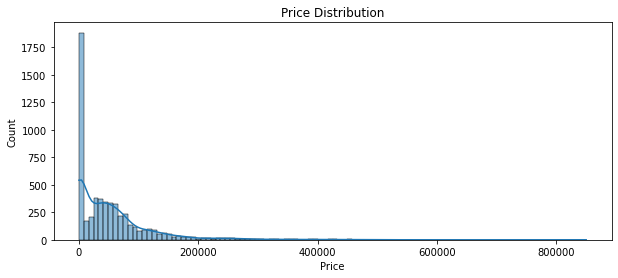

In [49]:
# Distribution Plot untuk Price
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='Price', kde=True)
plt.title('Price Distribution')
plt.show()

Berdasarkan Distirbusion Plot, harga mobil mayoritas ada di harga 0, hal ini dikarenakan para penjual mobil memilih opsi *negotiable*, dimana calon pembeli dapat menawar harga yang mereka inginkan, jika penjual setuju dengan harga yang ditawarkan oleh calon pembeli, maka transaksi dapat berlangsung

#### Distribution Mileage

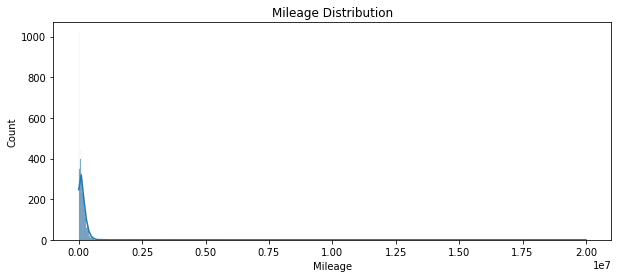

In [50]:
# Distribution Plot untuk Mileage
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='Mileage', kde=True)
plt.title('Mileage Distribution')
plt.show()

Disini adanya persebaran data Mileage sangat Right Skew

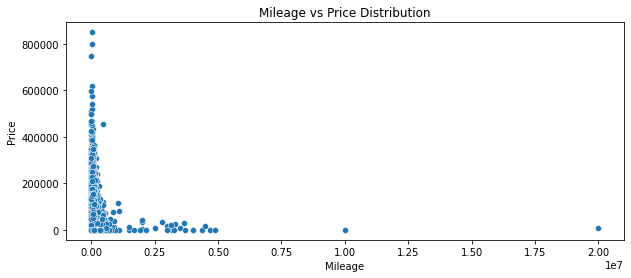

In [51]:
plt.figure(figsize=(10,4))
sns.scatterplot(data=df, x='Mileage', y='Price')
plt.title('Mileage vs Price Distribution')
plt.show()

terlihat bahwa pada mobil dengan `Mileage` yang rendah memiliki harga yang relative lebih mahal dibandingkan dengan mobil dengan `Mileage` tinggi

#### Gear Type

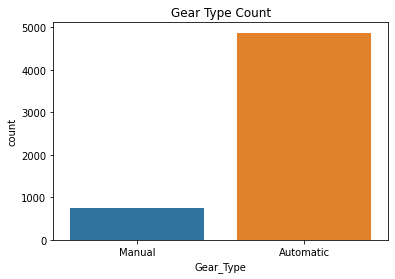

In [52]:
sns.countplot(data=df, x='Gear_Type')
plt.title('Gear Type Count')
plt.show()

Secara grafik diatas, dapat dilihat bahwa tipe tranmisi Automatic banyak dijual di platform ini

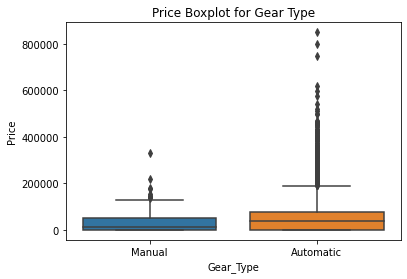

In [53]:
sns.boxplot(data=df, x='Gear_Type', y='Price')
plt.title('Price Boxplot for Gear Type')
plt.show()

secara harga, mobil dengan Gear Type Automatic memiliki harga rata-rata lebih tinggi daripada Manual

#### Region

In [54]:
df['Region'].value_counts()

Riyadh            2272
Dammam             925
Jeddah             733
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: Region, dtype: int64

Disini penjualan terbanyak ada di daerah Riyadh, untuk daerah-daerah lainnya dengan jumlah sedikit, akan dikumpulkan kedalam 1 kategori

#### Origin

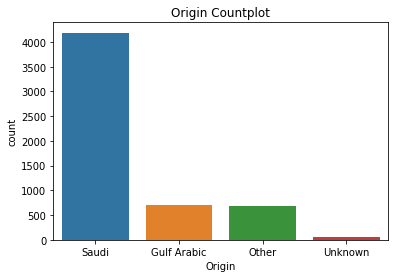

In [55]:
sns.countplot(data=df, x='Origin')
plt.title('Origin Countplot')
plt.show()

Untuk feature Origin, lokasi awal yang digunakan paling banyak adalah Saudi dan berikutnyba adalah Gulf Arabic. untuk bagian unknowns akan dimasukan ke bagian Other karena kita tidak tau lokasi awal apa yang digunakan oleh mereka

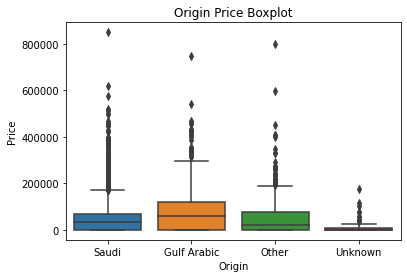

In [56]:
sns.boxplot(data=df, x='Origin', y='Price')
plt.title('Origin Price Boxplot')
plt.show()

Terlihat bahwa Origin tidak memiliki pengaruh terhadap harga

#### Engine Size

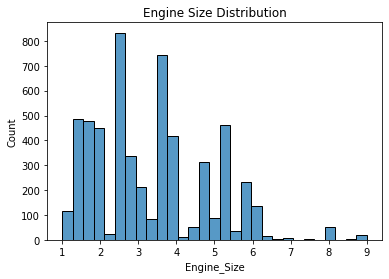

In [57]:
sns.histplot(data=df, x='Engine_Size')
plt.title('Engine Size Distribution')
plt.show()

Engine Size menunjukan kapasitas bahan bakar yang bisa dimasukan kedalam silinder mesin. Semakin tinggi artinya mobil semakin kuat/cepat

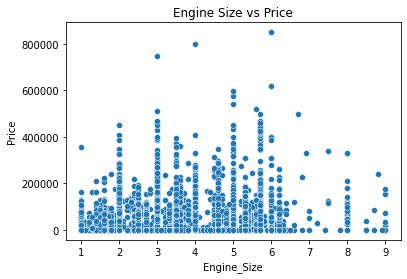

In [58]:
sns.scatterplot(data=df, x='Engine_Size', y='Price')
plt.title('Engine Size vs Price')
plt.show()

Engine Size terlihat tidak memiliki pengaruh terhadap harga 

#### Options

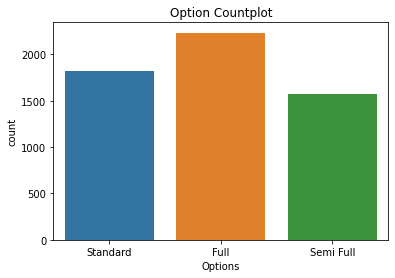

In [59]:
sns.countplot(data=df, x='Options')
plt.title('Option Countplot')
plt.show()

Terlihat bahwa mobil dengan `Option` Full memiliki jumlah paling banyak di *marketplace* ini

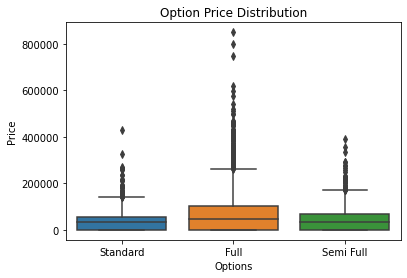

In [60]:
sns.boxplot(data=df, x='Options', y='Price')
plt.title('Option Price Distribution')
plt.show()

untuk kolom `Option`, menjelaskan bahwa mobil mana yang memilih opsi-opsi apa saja yang akan dimasukan kedalam mobil. Jika *Full*, maka mobil akan semakin mahal, sedangkan *Standard* akan lebih murah. Disini terlihat untuk opsi mobil *Full* akan memiliki nilai yang lebih mahal dibandingkan dengan kedua opsi lainnya.

#### Type

In [61]:
df['Type'].value_counts()

Land Cruiser    269
Camry           234
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: Type, Length: 347, dtype: int64

untuk tipe-tipe mobil, ada sebanyak 347 mobil yang dijual dan banyak mobil-mobil antik yang memiliki jumlah yang sedikit, hal ini akan menjadi kendala dalam Machine Learning. Sebelum ke proces modeling, tipe-tipe mobil yang memiliki jumlah kurang dari 50 akan dikelompokan menjadi 1 dengan nama *Other*

### Make

In [62]:
df['Make'].value_counts()

Toyota          1431
Hyundai          670
Ford             530
Chevrolet        458
Nissan           387
GMC              282
Kia              251
Mercedes         226
Lexus            222
Mazda            129
Honda            115
BMW               97
Dodge             95
Mitsubishi        94
Land Rover        79
Jeep              56
Chrysler          50
Audi              38
Changan           36
Renault           35
Cadillac          31
Genesis           31
Isuzu             25
Geely             24
Volkswagen        23
Porsche           22
MG                21
Suzuki            16
Lincoln           16
INFINITI          15
HAVAL             14
MINI              11
Other             10
Daihatsu           9
Jaguar             9
Mercury            9
Peugeot            8
Fiat               7
Hummer             5
Bentley            4
Great Wall         4
FAW                4
Rolls-Royce        3
Maserati           3
GAC                3
Foton              2
Zhengzhou          2
Aston Martin 

begitu juga dengan feature `Make`, untuk yang tidak memiliki jumlah diatas 10, akan dimasukan ke bagian *Other*

#### Negotiable

In [63]:
df['Negotiable'].value_counts()

False    3828
True     1796
Name: Negotiable, dtype: int64

1796 mobil yang dimasukan ke marketplace menggunakan sistem `Negotiable`. Untuk yang menggunakan sistem nego, mereka akan menaruh harga 0 di dalam sistem. Hal ini dapat mengganggu sistem Machine Learning kita, sehingga kita akan membuang data-data tersebut.

#### Year

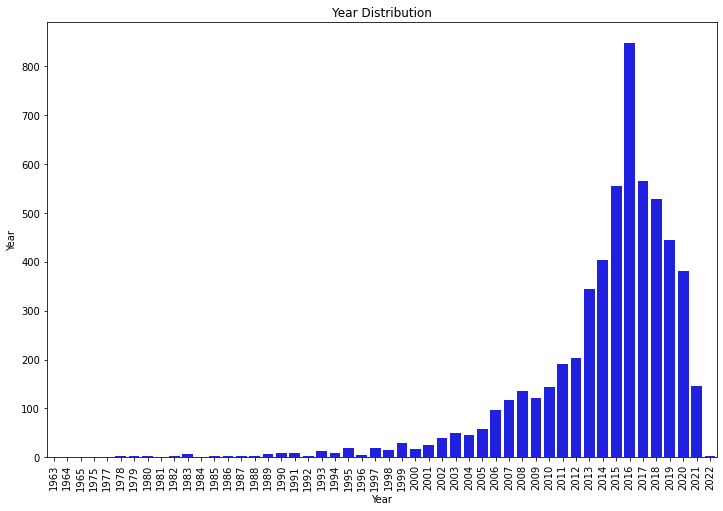

In [64]:
plt.figure(figsize=(12,8))
sns.barplot(data=df, x='Year', y='Year', estimator=len, color='b')
plt.title('Year Distribution')
plt.xticks(rotation=90)
plt.show()

Terlihat bahwa mobil yang cukup banyak ada pada jarak 2012-2022 dan memuncak pada tahun 2016 dan mulai menurun lagi. Hal ini cukup wajar karena mobil merupakan aset depresiasi dan akan tidak ada harganya lagi (menurut perusahaan) ketika sudah sampai 5 tahun, sehingga mobil yang memiliki umur 5-6 tahun akan banyak membanjiri *marketplace*

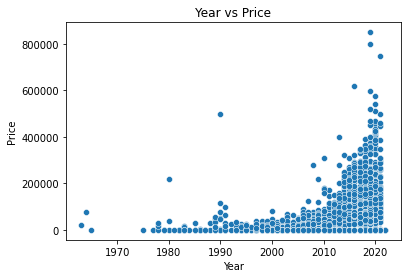

In [65]:
sns.scatterplot(data=df, x='Year', y='Price')
plt.title('Year vs Price')
plt.show()

Untuk data Tahun dan Harga terlihat adanya korelasi positif, untuk mobil yang semakin baru memiliki harga jual yang lebih tinggi dibandingkan dengan mobil lama

# **Data Preprocessing**

pada tahap ini, kita akan melakukan cleaning pada data kita. kita akan melakukan:
- Outlier Cleaning
- Input Missing Value
- Drop Column

### Categorical

In [66]:
df_model = df.copy()

In [67]:
# Mengecek jumlah NaN
df_model.isna().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [68]:
# mengecek jumlah duplikat
df_model.duplicated().sum()

4

melalui pengecekan sederhana, terlihat tidak ada data Nan Values. Hanya saja ketika kita melakukan EDA pada tahap sebelum ini, terlihat ada data yang diisi dengan *Unknow* pada fitur `Origin`. Untuk duplikat, hanya ada 4 data, kita cukup menghilangkan data tersebut

In [69]:
# drop duplikat
df_model.drop_duplicates(inplace=True)
df_model.shape

(5620, 11)

In [70]:
# melihat jumlah unique dan unique sample yang ada dalam tiap fitur
listItem = []

for col in df_model.columns:
    listItem.append([col, df_model[col].nunique(), df_model[col].unique()]);

df_model_desc = pd.DataFrame(columns=['Features', 'unique', 'uniqueSample'],
                     data=listItem)
df_model_desc


,Features,unique,uniqueSample
0,Type,347,"[Corolla, Yukon, Range Rover, Optima, FJ, CX3,..."
1,Region,27,"[Abha, Riyadh, Hafar Al-Batin, Aseer, Makkah, ..."
2,Make,58,"[Toyota, GMC, Land Rover, Kia, Mazda, Porsche,..."
3,Gear_Type,2,"[Manual, Automatic]"
4,Origin,4,"[Saudi, Gulf Arabic, Other, Unknown]"
5,Options,3,"[Standard, Full, Semi Full]"
6,Year,50,"[2013, 2014, 2015, 2020, 2019, 2012, 2016, 199..."
7,Engine_Size,71,"[1.4, 8.0, 5.0, 2.4, 4.0, 2.0, 4.8, 3.5, 4.6, ..."
8,Mileage,1716,"[421000, 80000, 140000, 220000, 49000, 25000, ..."
9,Negotiable,2,"[True, False]"


#### Origin

seakrang terlihat adanya data NaN Values yang tidak terlihat melalui function yang disediakan oleh Pyhton, yaitu pada feature `Origin`. Untuk data tersebut akan dibuah ke *Other*

In [71]:
# mengubah kategori Unknown menjadi Other dalam fitur Origin
df_model['Origin'].replace('Unknown', 'Other', inplace=True)

#### Negotiable

Untuk fitur `Negotiable`, karena fitur tersebut hanya menjelaskan apakah mobil yang terjual dapat ditawar atau tidak, fitur tersebut tidak memiliki pengaruh harga terhadap mobil. Jadi berdasarkan pertimbangan tersebut, kita tidak akan menggunakan fitur tersebut untuk model machine learning

In [72]:
# membuang fitur Negotiable
df_model.drop(columns='Negotiable', inplace=True)

#### Type

untuk `Type` mobil. ketika jumlah tiap kategori lebih sedikit dari 3, mereka akan dikelompokan menjadi 1 kategori, karena dapat dibilang bahwa mobil tersebut sebagai mobil langka/tidak umum, sehingga kita tidak punya cukup data untuk mempelajari `Type` mobil tersebut

In [73]:
# mengubah tipe mobil yang memiliki jumlah dibawah 3 menjadi Other
type_change_index = df_model['Type'].value_counts().loc[lambda x : x < 3].index
df_model.loc[df_model['Type'].isin(type_change_index), 'Type'] = 'Other'

#### Make

begitu juga untuk `Make`, kita akan mengelompokkan categori yang lebih sedikit dari 3

In [74]:
# mengubah merek mobil yang memiliki jumlah dibawah 3 menjadi Other
make_change_index = df_model['Make'].value_counts().loc[lambda x : x < 3].index
df_model.loc[df_model['Make'].isin(make_change_index), 'Make'] = 'Other'

#### Region

begitu juga untuk `Region`, kita akan mengelompokkan categori yang lebih sedikit dari 20

In [75]:
# mengubah region yang memiliki jumlah dibawah 20 menjadi Other
make_change_index = df_model['Region'].value_counts().loc[lambda x : x < 20].index
df_model.loc[df_model['Region'].isin(make_change_index), 'Region'] = 'Other'

### Numerical

In [76]:
# Simple Function untuk mengecek outliers
def up_bot_limit(column):
    q1 = df_model[column].describe()['25%']
    q3 = df_model[column].describe()['75%']
    iqr = q3 - q1
    limit_bawah = q1 - (iqr*1.5)
    limit_atas = q3 + (iqr*1.5)
    print(f'Limit Bawah {limit_bawah}')
    print(f'Limit Atas {limit_atas}')

In [77]:
# mengecek setiap outlier menggunakan looping
for i in df_model.describe().columns :
    print(i)
    up_bot_limit(i)
    print()

Year
Limit Bawah 2003.0
Limit Atas 2027.0

Engine_Size
Limit Bawah -1.75
Limit Atas 8.25

Mileage
Limit Bawah -199000.0
Limit Atas 433000.0

Price
Limit Bawah -109500.0
Limit Atas 182500.0



Sekarang terlihat setiap batas atas dan batas bawah untuk setiap fitur Numerikal. Kita akan menggunakan kombinasi dari metode IQR dan juga domain knowledge untuk membersihkan data dari outliers. Di luar rentang data, hasil prediksi dari model menjadi tidak akurat.

#### Price

In [78]:
# mengecek berapa persen jumlah mobil yang harganya 0
df_model[df_model['Price'] == 0].count()['Price'] / len(df_model)

0.3195729537366548

Sekitar 31.95% mobil tertulis dengan harga 0 oleh sistem. Hal ini dikarenakan penjual menyalakan fitur `Negotiable` di market. Secara logika, tidak mungkin penjual memasukan harga 0 alias gratis dalam marketplace, sehingga kita dapat membuang mobil-mobil dengan harga 0 yang ada dalam data.

In [79]:
# Filtering Data
df_model = df_model[df_model['Price'] > 0]
df_model.shape

(3824, 10)

Untuk outlier, harga dibawah 10.000 akan dibuang karena harga tersebut outlier karena terlalu murah untuk mobil second, dan kita akan membuang mobil dengan harga diatas 400.000 karena terlalu jauh dari kumpulan harga

In [80]:
# Filtering Data
df_model = df_model[df_model['Price'] < 400000]
df_model = df_model[df_model['Price'] > 10000]
df_model.shape

(3669, 10)

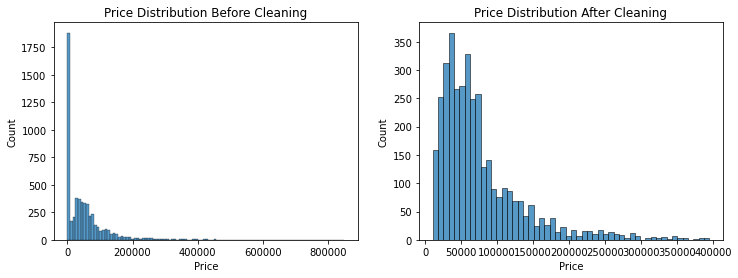

In [81]:
plt.figure(figsize=(12,4))

# Distribution plot sebelum filtering
plt.subplot(1,2,1)
sns.histplot(data=df, x='Price')
plt.title('Price Distribution Before Cleaning')

# Distirbution plot setelah filtering
plt.subplot(1,2,2)
sns.histplot(data=df_model , x='Price')
plt.title('Price Distribution After Cleaning')

plt.show()

#### Year

In [82]:
# cek jumlah data yang memiliki mobil dibawah tahun 2003
len(df_model[df_model['Year'] < 2003])

91

Untuk fitur `Year`, kita akan menggunakan metode IQR untuk membuang outier yang ada pada limit bawah. Terdapat 91 mobil yang memiliki tahun lebih tua dari tahun 2003

In [83]:
# Filtering Data
df_model = df_model[df_model['Year'] > 2003]
df_model.shape

(3560, 10)

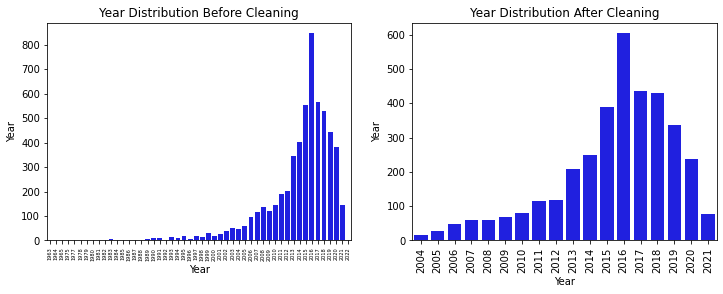

In [84]:
plt.figure(figsize=(12,4))

# Distribution Plot sebelom filtering
plt.subplot(1,2,1)
sns.barplot(data=df , x='Year', y='Year', estimator=len, color='b')
plt.xticks(rotation=90, size=5)
plt.title('Year Distribution Before Cleaning')

# Distribution plot setelah filtering
plt.subplot(1,2,2)
sns.barplot(data=df_model , x='Year', y='Year', estimator=len, color='b')
plt.xticks(rotation=90)
plt.title('Year Distribution After Cleaning')

plt.show()

#### Engine Size

In [85]:
# cek jumlah data yang memiliki mobil dengan engine size diatas 6
len(df_model[df_model['Engine_Size'] > 6])

68

Untuk fitur `Engine_Size`, dengan mempertimbangkan domain knowledge dan melihat persebaran data engine size, diputuskan untuk membuang mobil dengan engine size diatas 6 karena jauh dari kumpulan data. Terdapat 68 mobil yang memiliki engine size diatas 6

In [86]:
# Filtering Data
df_model = df_model[df_model['Engine_Size'] < 6]
df_model.shape

(3439, 10)

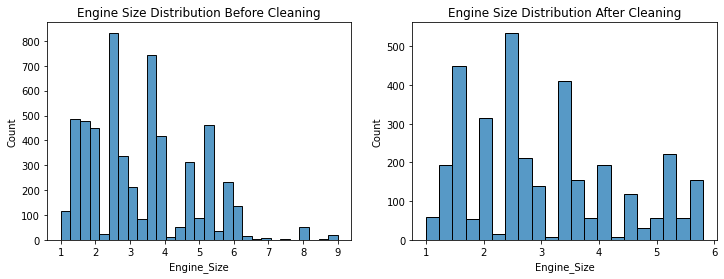

In [87]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(data=df , x='Engine_Size')
plt.title('Engine Size Distribution Before Cleaning')

plt.subplot(1,2,2)
sns.histplot(data=df_model , x='Engine_Size')
plt.title('Engine Size Distribution After Cleaning')

plt.show()

#### Mileage

In [88]:
# mengecek jumlah mobilk dengan mileage diatas 433.000
len(df_model[df_model['Mileage'] > 433000])

51

Untuk fitur `Mileage`, kita akan menggunakan metode IQR untuk menentukan batas atas outlier, yaitu 433.000. Terdapat 51 mobil yang memiliki mileage diatas 433.000

In [89]:
# data filtering
df_model = df_model[df_model['Mileage'] < 433000]
df_model.shape

(3387, 10)

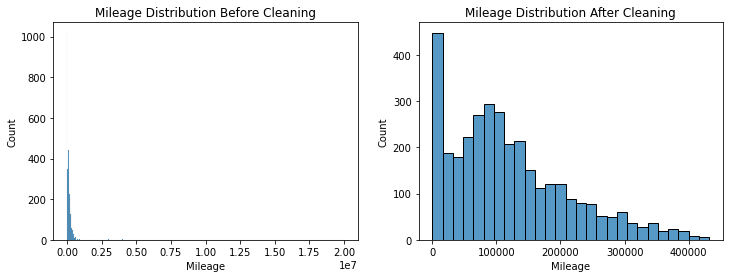

In [90]:
plt.figure(figsize=(12,4))

# distribusi plot sebelum filtering
plt.subplot(1,2,1)
sns.histplot(data=df , x='Mileage')
plt.title('Mileage Distribution Before Cleaning')

# distribusi plot setelah filtering
plt.subplot(1,2,2)
sns.histplot(data=df_model , x='Mileage')
plt.title('Mileage Distribution After Cleaning')

plt.show()

#### Check Dataset

Sekarang kita akan mengecek sekali lagi semua dataframe yang sudah di ubah

In [91]:
listItem = []

for col in df_model.columns:
    listItem.append([col, df_model[col].nunique(), df_model[col].unique()]);

df_model_desc = pd.DataFrame(columns=['Features', 'unique', 'uniqueSample'],
                     data=listItem)
df_model_desc


,Features,unique,uniqueSample
0,Type,193,"[Range Rover, Optima, CX3, Cayenne S, Sonata, ..."
1,Region,22,"[Riyadh, Hafar Al-Batin, Abha, Makkah, Dammam,..."
2,Make,44,"[Land Rover, Kia, Mazda, Porsche, Hyundai, Toy..."
3,Gear_Type,2,"[Automatic, Manual]"
4,Origin,3,"[Gulf Arabic, Saudi, Other]"
5,Options,3,"[Full, Semi Full, Standard]"
6,Year,18,"[2015, 2019, 2012, 2016, 2013, 2011, 2008, 202..."
7,Engine_Size,48,"[5.0, 2.4, 2.0, 4.8, 3.5, 5.7, 4.6, 4.0, 3.0, ..."
8,Mileage,1198,"[140000, 220000, 25000, 189000, 155, 110864, 2..."
9,Price,361,"[260000, 42000, 58000, 85000, 48000, 81500, 55..."


In [92]:
df_model.shape

(3387, 10)

pada awalnya, kita memiliki 5624 baris data, sekarang kita memiliki data bersih sebanyak 3387 baris data. Sekarang kita akan menggunakan data tersebut untuk melakukan pemodelan

# Modeling

#### Encoding

pada tahap ini, kita akan mengubah beberapa fitur kategorikal yang terpilih menjadi fitur numerikal, fitur kategorikal yang akan kita ubah:
- onehot : `Gear_Type`, `Origin`
    - Dikarenakan tidak adanya hubungan/urutan didalam fitur ini, saya memutuskan untuk menggunakan onehot
- ordinal : `Options`
    - untuk fitur `Options` dikarenakan adanya urutan yang ada dalam fitur kategorikal ini, saya memutuskan untuk menggunakan ordinal encoding
- binary : `Type`, `Region`, `Make`
    - Dikarenakan fitur `Type`, `Region`, dan `Make` memiliki kategori yang cukup banyak, ketika kita menggunakan onehot akan menghasilkan column yang banyak karena sistem encoding onehot akan menghasilkan column baru berdasar jumlah unique yang ada. Untuk meringankan sistem machine learning, saya memutuskan untuk menggunakan binary encoding agar tidak tercipta column yang banyak.


In [93]:
# ordinal mapping untuk fitur Options
ordinal_mapping = [
    {'col':'Options',
    'mapping' :{
        'Standard' : 1, 
        'Semi Full' : 2,
        'Full' : 3
    }}
]

In [94]:
# columntransformer untuk mengubah fitur kategorikal menjadi numerikal sebelum di fitting terhadap machine learning
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'),['Gear_Type','Origin']),
    ('ordinal', OrdinalEncoder(cols=['Options'], mapping=ordinal_mapping),['Options']),
    ('binary', BinaryEncoder(),['Type','Region','Make'])
], remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot', OneHotEncoder(drop='first'),
                                 ['Gear_Type', 'Origin']),
                                ('ordinal',
                                 OrdinalEncoder(cols=['Options'],
                                                mapping=[{'col': 'Options',
                                                          'mapping': {'Full': 3,
                                                                      'Semi Full': 2,
                                                                      'Standard': 1}}]),
                                 ['Options']),
                                ('binary', BinaryEncoder(),
                                 ['Type', 'Region', 'Make'])])

### Data Splitting

In [95]:
# memisahkan data variable dengan target
X = df_model.drop(columns=['Price'])
y = df_model['Price']

### Train and Test Split

In [96]:
# split data menjadi train dan test set dengan proporsi 80:20
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Benchmark Model

In [97]:
# Algorithm Machine Learning
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1)
aboost = AdaBoostRegressor(random_state=1)
gboost = GradientBoostingRegressor(random_state=1)

# Scaling
standard = StandardScaler()
robust = RobustScaler()
minmax = MinMaxScaler()

In [98]:
models = [lr,lasso,ridge,knn,dt,rf,aboost,gboost]

mean_rmse = []
std_rmse = []

mean_mae = []
std_mae = []

mean_mape = []
std_mape = []

scoring = {'rmse':'neg_root_mean_squared_error',
            'mae':'neg_mean_absolute_error',
            'mape':'neg_mean_absolute_percentage_error'}
for algo in models:
    model_pipe = Pipeline([
        ('transformer', transformer),
        ('scaler',robust),
        ('algo',algo)
    ])

    model_cv = cross_validate(
        estimator=model_pipe,
        X=X_train,
        y=y_train,
        cv=5,
        scoring=scoring,
    )

    mean_rmse.append(model_cv['test_rmse'].mean())
    std_rmse.append(model_cv['test_rmse'].std())
    mean_mae.append(model_cv['test_mae'].mean())
    std_mae.append(model_cv['test_mae'].std())
    mean_mape.append(model_cv['test_mape'].mean())
    std_mape.append(model_cv['test_mape'].std())

In [99]:
pd.DataFrame({
    'Model': ['linreg','lasso','ridge','knn','dt','rf','adaboost','gradientboost'],
    'Mean_RMSE': mean_rmse,
    'Std_RMSE': std_rmse,
    'Mean_MAE': mean_mae,
    'Std_MAE': std_mae,
    'Mean_MAPE': mean_mape,
    'Std_MAPE': std_mape
})

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
0,linreg,-38128.345952,2219.365026,-25718.996346,1130.615636,-0.466091,0.038938
1,lasso,-38128.205002,2219.618723,-25717.836926,1130.908755,-0.466047,0.038943
2,ridge,-38126.592259,2225.196500,-25707.486244,1134.831537,-0.465680,0.038928
3,knn,-28095.130072,1352.762271,-17072.657414,456.453315,-0.278923,0.014311
4,dt,-36161.326154,2412.494653,-19464.966814,1025.742740,-0.293301,0.015243
5,rf,-25516.561168,1857.875026,-15057.904141,570.719734,-0.239897,0.017664
6,adaboost,-42609.645411,797.322983,-35522.442399,1309.266238,-0.744294,0.060726
7,gradientboost,-28146.551140,1601.051638,-17463.658161,716.967558,-0.268981,0.022434


dalam memilih model yang baik, kita harus mencari model yang memiliki nilai RMSE, MAE dan MAPE yang kecil. Dari hasil test, yang memiliki nilai terkecil adalah:
- K-Nearest Neighbor (Terpilih karena memiliki nilai RMSE, MAE dan MAPE yang terkecil kedua tetapi memiliki model yang stabil)
- Random Forest (Terpilih karena memiliki nilai RMSE, MAE dan MAPE yang kecil)

### Hyperparameter Tuning

setelah ini kita akan melakukan Hyperparameter tuning kepada 2 model tersebut dan akan kita test terhadap test set, yang memiliki nilai terkecil akan kita ambil menjadi model akhir kita

#### K-Nearest Neighbor

Randomize Search

In [100]:
# Define Model
model_pipe_knn = Pipeline([
    ('transformer', transformer),
    ('scaler',robust),
    ('algo',knn)
])

# Hyper Parameter Combination
hyper_param_random = {
    'scaler' : [robust,minmax,standard],
    'algo__n_neighbors' : range(3,100,2),
    'algo__weights' : ['uniform','distance'],
    'algo__leaf_size' : range(10,100,2)
}

# Random Search
random_search_knn = RandomizedSearchCV(
    estimator = model_pipe_knn,
    param_distributions=hyper_param_random,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    n_iter=300,
    random_state=0
)


In [101]:
random_search_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Gear_Type',
                                                                                'Origin']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(cols=['Options'],
                                                                                              mapping=[{'col': 'Options',
                                                                                                        'mapping': {'Full': 3,
                                                                                                                    'Semi Full': 2,
                                                                                                                    'Standard': 1}}]),
                                                                               ['Options']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                                                                               ['Type',
                                                                                'Region',
                                                                                'Make'])])),
                                             ('scaler', RobustScaler()),
                                             ('algo', KNeighborsRegressor())]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'algo__leaf_size': range(10, 100, 2),
                                        'algo__n_neighbors': range(3, 100, 2),
                                        'algo__weights': ['uniform',
                                                          'distance'],
                                        'scaler': [RobustScaler(),
                                                   MinMaxScaler(),
                                                   StandardScaler()]},
                   random_state=0, scoring='neg_mean_absolute_error')

In [102]:
random_search_knn.best_params_

{'scaler': RobustScaler(),
 'algo__weights': 'distance',
 'algo__n_neighbors': 5,
 'algo__leaf_size': 50}

In [103]:
random_search_knn.best_score_

-15987.763574220988

Grid Search

In [104]:
# Define Model
model_pipe_knn = Pipeline([
    ('transformer', transformer),
    ('scaler',robust),
    ('algo',knn)
])

# Hyperparameter Combination
hyper_param_grid_knn = {
    'scaler' : [robust,minmax,standard],
    'algo__n_neighbors' : range(5,20,2),
    'algo__weights' : ['uniform','distance'],
    'algo__leaf_size' : range(30,41,1)
}

# Grid Search
grid_search_knn = GridSearchCV(
    estimator = model_pipe_knn,
    param_grid=hyper_param_grid_knn,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

In [105]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Gear_Type',
                                                                          'Origin']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cols=['Options'],
                                                                                        mapping=[{'col': 'Options',
                                                                                                  'mapping': {'Full': 3,
                                                                                                              'Semi Full': 2,
                                                                                                              'Standard': 1}}]),
                                                                         ['Options']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['Type',
                                                                          'Region',
                                                                          'Make'])])),
                                       ('scaler', RobustScaler()),
                                       ('algo', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'algo__leaf_size': range(30, 41),
                         'algo__n_neighbors': range(5, 20, 2),
                         'algo__weights': ['uniform', 'distance'],
                         'scaler': [RobustScaler(), MinMaxScaler(),
                                    StandardScaler()]},
             scoring='neg_mean_absolute_error')

In [106]:
grid_search_knn.best_params_

{'algo__leaf_size': 30,
 'algo__n_neighbors': 5,
 'algo__weights': 'distance',
 'scaler': RobustScaler()}

In [107]:
grid_search_knn.best_score_

-15987.763574220988

#### Random Forest

 Randomize Search

In [108]:
model_pipe_rf = Pipeline([
    ('transformer', transformer),
    ('scaler',robust),
    ('algo',rf)
])

hyper_param_random = {
    'scaler' : [robust,minmax,standard],
    'algo__n_estimators' : range(100,200,10),
    'algo__max_depth' : range(1,100,1),
    'algo__min_samples_split' : range(2,100,2),
    'algo__min_samples_leaf' : range(1,100,1)
}

random_search_rf = RandomizedSearchCV(
    estimator = model_pipe_rf,
    param_distributions=hyper_param_random,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    n_iter=300,
    random_state=0
)

In [109]:
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Gear_Type',
                                                                                'Origin']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(cols=['Options'],
                                                                                              mapping=[{'col': 'Options',
                                                                                                        'mapping': {'Full': 3,
                                                                                                                    'Semi Full': 2,
                                                                                                                    'Standard': 1}}]),
                                                                               ['Options']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                                                                               ['Type',
                                                                                '...
                                             ('scaler', RobustScaler()),
                                             ('algo',
                                              RandomForestRegressor(random_state=1))]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'algo__max_depth': range(1, 100),
                                        'algo__min_samples_leaf': range(1, 100),
                                        'algo__min_samples_split': range(2, 100, 2),
                                        'algo__n_estimators': range(100, 200, 10),
                                        'scaler': [RobustScaler(),
                                                   MinMaxScaler(),
                                                   StandardScaler()]},
                   random_state=0, scoring='neg_mean_absolute_error')

In [110]:
random_search_rf.best_params_

{'scaler': RobustScaler(),
 'algo__n_estimators': 130,
 'algo__min_samples_split': 2,
 'algo__min_samples_leaf': 2,
 'algo__max_depth': 95}

In [111]:
random_search_rf.best_score_

-15037.752433578804

Grid Search

In [112]:
model_pipe_rf = Pipeline([
    ('transformer', transformer),
    ('scaler',robust),
    ('algo',rf)
])

hyper_param_grid_rf = {
    'scaler' : [robust],
    'algo__n_estimators' : range(165,171,5),
    'algo__max_depth' : range(45,49,1),
    'algo__min_samples_split' : range(4,7,2),
    'algo__min_samples_leaf' : range(1,4,1)
}


grid_search_rf = GridSearchCV(
    estimator = model_pipe_rf,
    param_grid=hyper_param_grid_rf,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)

In [113]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Gear_Type',
                                                                          'Origin']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cols=['Options'],
                                                                                        mapping=[{'col': 'Options',
                                                                                                  'mapping': {'Full': 3,
                                                                                                              'Semi Full': 2,
                                                                                                              'Standard': 1}}]),
                                                                         ['Options']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['Type',
                                                                          'Region',
                                                                          'Make'])])),
                                       ('scaler', RobustScaler()),
                                       ('algo',
                                        RandomForestRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'algo__max_depth': range(45, 49),
                         'algo__min_samples_leaf': range(1, 4),
                         'algo__min_samples_split': range(4, 7, 2),
                         'algo__n_estimators': range(165, 171, 5),
                         'scaler': [RobustScaler()]},
             scoring='neg_mean_absolute_error')

In [114]:
grid_search_rf.best_params_

{'algo__max_depth': 45,
 'algo__min_samples_leaf': 2,
 'algo__min_samples_split': 4,
 'algo__n_estimators': 165,
 'scaler': RobustScaler()}

In [115]:
grid_search_rf.best_score_

-15022.464980586305

### Predict to Test Set

Melakukan prediksi pada test set dengan model KNN dan Random Forest dengan basic algoritma dan Hyperparameter yang terpilih untuk memperlihatkan perkembangan model

#### K-Nearest Neighbor

Basic

In [116]:
# Model Transform
model_pipe_knn = Pipeline([
    ('transformer', transformer),
    ('scaler',robust),
    ('algo',knn)
])

# Train Model
model_pipe_knn.fit(X_train, y_train)

# Predict to Test Set
y_pred_basic_knn = model_pipe_knn.predict(X_test)

# Find the metric score
rmse_knn_basic = np.sqrt(mean_squared_error(y_test,y_pred_basic_knn))
mae_knn_basic = mean_absolute_error(y_test,y_pred_basic_knn)
mape_knn_basic = mean_absolute_percentage_error(y_test,y_pred_basic_knn)

Tuned

In [117]:
# Define Best model KNN
best_model_knn = grid_search_knn.best_estimator_

# Train Model
best_model_knn.fit(X_train, y_train)

# Predict to Test Set
y_pred_best_knn = best_model_knn.predict(X_test)

# Find the metric score
rmse_knn_best = np.sqrt(mean_squared_error(y_test,y_pred_best_knn))
mae_knn_best = mean_absolute_error(y_test,y_pred_best_knn)
mape_knn_best = mean_absolute_percentage_error(y_test,y_pred_best_knn)

#### Random Forest

Basic

In [118]:
# Model Transform
model_pipe_rf = Pipeline([
    ('transformer', transformer),
    ('scaler',robust),
    ('algo',rf)
])

# Train Model
model_pipe_rf.fit(X_train, y_train)

# Predict to Test Set
y_pred_basic_rf = model_pipe_rf.predict(X_test)

# Find the metric score
rmse_rf_basic = np.sqrt(mean_squared_error(y_test,y_pred_basic_rf))
mae_rf_basic = mean_absolute_error(y_test,y_pred_basic_rf)
mape_rf_basic = mean_absolute_percentage_error(y_test,y_pred_basic_rf)

Tuned

In [119]:
# Define Best model RF
best_model_rf = grid_search_rf.best_estimator_

# Train Model
best_model_rf.fit(X_train, y_train)

# Predict to Test Set
y_pred_best_rf = best_model_rf.predict(X_test)

# Find the metric score
rmse_rf_best = np.sqrt(mean_squared_error(y_test,y_pred_best_rf))
mae_rf_best = mean_absolute_error(y_test,y_pred_best_rf)
mape_rf_best = mean_absolute_percentage_error(y_test,y_pred_best_rf)

Hasil prediksi pada test set before vs after tuning

In [120]:
# memperlihatkan tabel rmse, mae dan mape setiap model
pd.DataFrame({
    'model' : ['knn basic','knn best','rf basic', 'rf best'],
    'rmse' : [rmse_knn_basic,rmse_knn_best,rmse_rf_basic,rmse_rf_best],
    'mae' : [mae_knn_basic,mae_knn_best,mae_rf_basic,mae_rf_best],
    'mape' : [mape_knn_basic,mape_knn_best,mape_rf_basic,mape_rf_best]
})

,model,rmse,mae,mape
0,knn basic,29465.497340,16742.580531,0.258017
1,knn best,28643.521049,15935.165660,0.244436
2,rf basic,25566.368953,14376.055688,0.209601
3,rf best,25519.249609,14322.650561,0.208964


Model KNN dan RF memiliki peningkatan performa setelah melakukan Hyperparameter Tuning pada nilai RMSE, MAE dan MAPE. Hanya saja untuk model RF, tidak begitu terlihat peningkatan pada model dikarenakan penurunan yang tidak begitu signifikan setelah dilakukan Hyperparameter Tuning. Meski dengan menggunakan model basic (default setting), model Random Forest terlihat sudah lebih baik dibandingkan dengan KNN. Oleh karena itu, Kita akan menggunakan model Random Forest sebagai model Akhir.

##### Residual Error

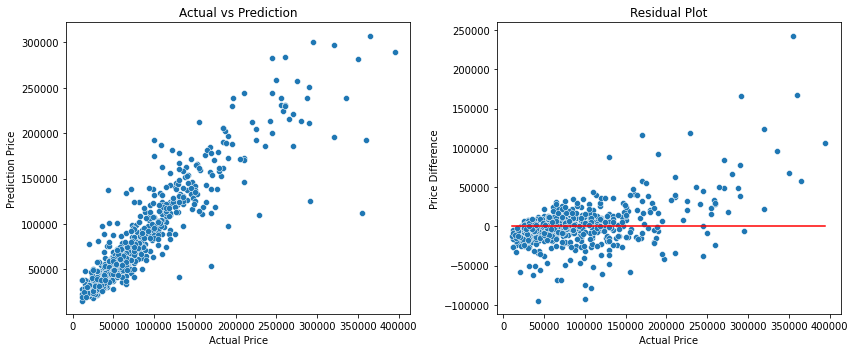

In [121]:
plt.figure(figsize=(12,5))

# Plot untuk actual vs prediction
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred_best_rf)
plt.title('Actual vs Prediction')
plt.xlabel('Actual Price')
plt.ylabel('Prediction Price')

# plot untuk error residual
plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=(y_test-y_pred_best_rf))
sns.lineplot(x=y_test, y=0, color='red')
plt.title('Residual Plot')
plt.xlabel('Actual Price')
plt.ylabel('Price Difference')

plt.tight_layout()
plt.show()

adanya nilai error yang tinggi membuat nilai RMSE dan MAE berbeda cukup signifikan. dapat dilihat pula pada Error Residual, adanya overestimation dan juga underestimation. Akan tetapi, nilai MAPE yang didapat adalah sekitar 20.8%, sehingga model ini masuk ke kategori 'Reasonable Forecasting'(Lewis, 1982).

*Source: Lewis, C.D. (1982). Industrial and business forecasting methods: A practical guide to exponential smoothing and curve fitting*

### Feature Importances

Untuk mengetahui fitur apa saja yang mempengaruhi target, kita dapat mengeceknya.

c:\Users\aaron\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


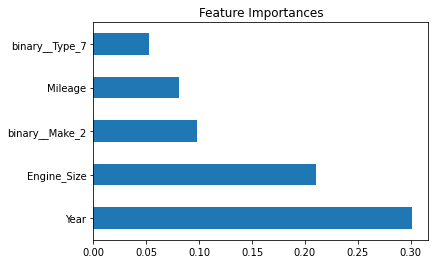

In [122]:
# fitur-fitur yang mempengaruhi harga mobil
feature_imp = pd.Series(best_model_rf[2].feature_importances_,transformer.get_feature_names()).sort_values(ascending=False).head()
feature_imp.plot(kind='barh', title='Feature Importances')
plt.show()

# Conclusion

Berdasarkan pemodelan yang sudah dilakukanm fitur `Year` dan `Engine_Size` menjadi fitur yang paling penting terhadap `Price`.

Metrik evaluasi yang digunakan adalah RMSE, MAE & MAPE. Jika ditinjau dari nilai MAPE yang dihasilkan model, yaitu sebesar 20.89%, kita dapat menyimpulan bahwa model yang kita buat ini mampu memperkirakan harga mobil dengan rata-rata error sebesar 20.89% dari harga yang mungkin seharusnya. 

Model yang dibuat hanya mampu meprediksi harga mobil dengan performa seperti di atas jika mobil memiliki feature:
- `Year` : 2003 - 2020
- `Mileage` : 0 - 433.000
- `Engine_Size` : 1 - 6
- `Price` : 10.000 - 400.000

# Recommendation

Hal-hal yang dapat dilakukan untuk pengembangan model agar lebih baik lagi

1. Menambah data-data untuk mobil-mobil langka/antik agar tidak dikelompokkan menjadi 1, sehingga model machine learning bisa mempelajari tipe-tipe yang serupa/mendekati mobil tersebut

2. mengecek prediksi yang memiliki error tinggi secara manual, sehingga kita bisa melakukan pengecekan variable apa saja yang membuat error tinggi

3. penambahan fitur yang memiliki korelasi terhadap target, seperti kerusakan yang pernah dialami atau deskripsi kerusakan saat mobil dijual

4. diharapkan untuk menulis tipe mobil yang lengkap untuk model lebih bisa mempelajari tipe-tipe mobil. Contoh kasus, Volkswagen Type Van, tidak ditulis lengkap tipe Van yang dimaksud penjual

# Pickle

Save Model

In [123]:
# Save Model
# import pickle

# best_model = grid_search_rf.best_estimator_

# best_model.fit(X,y)

# pickle.dump(best_model, open('Used_Car_ML.sav', 'wb'))

Load Model

In [124]:
# Load Model
# loaded_model = pickle.load(open('Used_Car_ML.sav', 'rb'))